# Make tables: calculate p-values and differential expressions for each cancer 

Create a dataframe with p-value results from t-tests for all proteins (trans proteomics when KRAS has missense mutations compared to KRAS wildtype). The dataframe also includes the change in medians between deletions and wildtype. Prepare these tables for further analysis by creating csv files.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u
import plot_utils as p

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Returns a dataframe with proteomics and mutation type

# all_prot: list of trans genes

def all_prot_format_df(cancer_object, all_prot, gene_in = 'KRAS', utils = u):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    mut_type['Mutation'].where(mut_type['Mutation'] != 'Missense_Mutation', 'Missense', inplace = True) # replace when false
    mut_type['Mutation'].where(mut_type['Mutation'] != 'nonsynonymous SNV', 'Missense', inplace = True)

    # Keep only tumor samples from proteomics
    prot_and_mutations = cancer_object.join_omics_to_mutations(
        mutations_genes = [gene_in], omics_df_name = 'phosphoproteomics', omics_genes = all_prot, tissue_type = 'tumor')
    # Reduce a multiindex 
    if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
        if cancer_object.get_cancer_type() in ('endometrial', 'colon'):
            prot_and_mutations = u.reduce_multiindex(prot_and_mutations, flatten=True) 
        elif cancer_object.get_cancer_type() in ('luad'):
            prot_and_mutations = u.reduce_multiindex(prot_and_mutations, levels_to_drop = [2,3], flatten = True) 
        prot_and_mutations = rename_duplicate_cols(prot_and_mutations)

    # Keep certain missense mutations
    prot_and_mutations['KRAS_Location'] = [','.join(map(str, l)) for l in prot_and_mutations['KRAS_Location']]
    hotspots = ['G12', 'G13', 'Q61', 'No_mutation']
    hotspots_wt = pd.DataFrame()
    for site in hotspots:
        df = prot_and_mutations[prot_and_mutations.KRAS_Location.str.contains(site, regex= True, na=False)]
        hotspots_wt = hotspots_wt.append(df)
    #print(hotspots_wt.KRAS_Location.value_counts())
    
    # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
    mut_type = mut_type[['Mutation']]
    prot_df = hotspots_wt.iloc[:,:-4] # Keep only proteomics
    merged = prot_df.join(mut_type)
    merged = merged.join(hotspots_wt['KRAS_Location'])

    # Keep only Wildtype and deletion
    compare = ['Wildtype_Tumor','Missense']
    get = merged['Mutation'].isin(compare)
    mut_wt = merged[get]
    
    mut_wt = mut_wt.rename(columns={col: re.sub(r'_phosphoproteomics', '', col) for col in mut_wt.columns.tolist()})
    return mut_wt


In [4]:
'''
Params
cancer_object: Object. Variable for the loaded cancer data set.
cancer_name: Str. name to add to the created dataframe.
del_wt_df: DataFrame. Only samples with deletions and wildtype for PTEN. 
all_prot_list: List. All proteins in proteomics data frame. 

Returns a dataframe with the difference in medians between proteomics with PTEN wt and del (wt - del). 
'''

def get_change_in_medians_df(cancer_object, cancer_name, del_wt_df, all_prot_list):
    d = del_wt_df[del_wt_df.Mutation == "Missense"]
    wt = del_wt_df[del_wt_df.Mutation == "Wildtype_Tumor"]
    del_med = d.median()
    wt_med = wt.median()

    med_dict = {}
    
    # Correlation: + is mutant up compared to wt, - is mutant down
    for prot in all_prot_list:
        if prot in del_med.index and prot in wt_med.index:
            dif = del_med[prot] - wt_med[prot]
            med_dict[prot] = dif
        
    df = pd.DataFrame.from_dict(med_dict, orient='index', columns=[cancer_name+'_Median'])
    df = df.reset_index().rename(columns={'index':'Phosphoproteomics'})
    
    return df
        

In [5]:
# Adds '_i' to duplicate col names where i is a number (increases with each duplicate)

def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

In [6]:
def get_tumor_purity(cancer_obj):
    dm = cancer_obj.get_derived_molecular()
    # Rename to make consistent tumor purtity col
    renamed_df = dm.rename(columns = {'TumorPurity':'Tumor_Purity','Purity_Cancer':'Tumor_Purity',
                                      'Tumor.Purity.byESTIMATE.RNAseq':'Tumor_Purity'})
    purity = renamed_df[['Tumor_Purity']]
    return purity

#  Step 1: Create data frames with p-values and differential expressions

Each cancer needs a data frame containing only samples that have PTEN cnv deletions and PTEN wildtype with trans proteomics. Use wrap_ttest to run t-tests for all genes in the proteomic data frame. Use get_change_in_medians_df to create the data frame with differential expression values. Merge both data frames. 

Load in cancer data sets from cptac. 

In [7]:
en = cptac.Endometrial()
l = cptac.Luad()
col = cptac.Colon()

In [8]:
egfr_path = ['EGFR', 'GRB2', 'GAB1', 'PIK3R1', 'PIK3CA', 'PDK1', 'AKT1', 'CASP9', 'BAD', 'MDM2', 'GSK3B',
                'FOXO1', 'RPS6KB1', 'EIF4EBP1', 'TSC2', 'CCND1', 'E2F1', 'RB1', 'CDKN1B', 'SHC1', 'SOS1', 'RAF1', 
                'SRC', 'MAP2K1', 'MAP2K2', 'MAPK3', 'MAPK1', 'BCL2L11', 'RPS6KA1', 'RPS6KA3', 'MKNK1', 'EIF4E',
                'ELK1', 'MYC', 'JUN', 'FOS']

# Calculate p-values and differential expressions

In [9]:
cancer_objects = {'Endo':en, 'Colon':col, 'Luad':l}

Endo
5%: 0.22946024
Num pure samples: 84 / 92 

Colon
5%: 0.557
Num pure samples: 76 / 81 

Luad
5%: 0.39836446978100504
Num pure samples: 80 / 85 



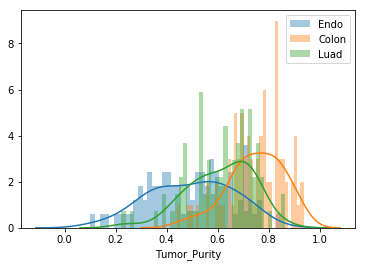

In [10]:
# Find tumor purity cutoffs 
purity_cutoff = {}

for c in cancer_objects:
    print(c)
    all_df = all_prot_format_df(cancer_objects[c], ['KRAS'], gene_in = 'KRAS')
    purity = get_tumor_purity(cancer_objects[c])
    miss_wt = all_df.join(purity, how = 'left')
    s = miss_wt['Tumor_Purity']

    #print('min:', s.min())
    #print('median:', s.median())
    #print('max:', s.max(), '\n')
    sns.distplot(s, bins = 40, label = c)
    plt.legend()
    #plt.show() # uncomment to see plots separately

    percent = 5
    cutoff = np.nanpercentile(s, percent, interpolation = 'nearest')
    purity_cutoff[c] = cutoff
    print(str(percent)+'%:', cutoff)
    print('Num pure samples:', len(s.loc[s > cutoff]), '/', len(all_df), '\n')# (of samples with miss/wt for KRAS not all samples

In [11]:
import warnings
warnings.filterwarnings('ignore')

#Uncomment to choose a get interacting function
#prot_list = list(u.get_interacting_proteins_bioplex(gene))
#prot_list = list(u.get_interacting_proteins_wikipathways(gene))
#prot_list = list(u.get_interacting_proteins_biogrid(gene, num_results=100))
#prot_list = list(u.get_interacting_proteins_string(gene, num_results=100))
prot_list = egfr_path

print('total interacting proteins:', len(prot_list))
gene = 'KRAS'
merged_dfs = {}
for cancer in cancer_objects:
    print(cancer)
    # Format df for t-test
    mut_wt = all_prot_format_df(cancer_objects[cancer], prot_list)
    mut_wt = mut_wt.dropna(axis = 'columns', how = 'all') # not enough data for cis effect (wrap_ttest drops)
    
    # Keep more pure tumors
    purity = get_tumor_purity(cancer_objects[cancer])
    mut_wt = mut_wt.join(purity, on = "Patient_ID", how = "left")
    mut_wt = mut_wt.loc[mut_wt['Tumor_Purity'] > purity_cutoff[cancer]]
    #print('cutoff:', purity_cutoff[cancer])
    print('\tmin tumor purity:', mut_wt.Tumor_Purity.min())
    
    # T-test
    cols_in = list(mut_wt.columns[:-3])
    print('cols tested: ', len(cols_in))

    # Get all pvals
    min_num = 5
    all_pval = u.wrap_ttest(mut_wt, 'Mutation', cols_in, return_all = True, correction_method = 'fdr_bh', mincount = min_num)
    all_pval = all_pval.rename(columns = {'Comparison': 'Phosphoproteomics','P_Value': cancer+'_P_Value'})
    
    # Get difference in medians
    delta_median_df = get_change_in_medians_df(cancer_objects[cancer], cancer, mut_wt, cols_in)

    # Merge pval_df and delta_median_df
    pval_medians_df = all_pval.merge(delta_median_df, on='Phosphoproteomics', how='outer')
    pval_medians_df = pval_medians_df.replace(to_replace = r'_phosphoproteomics', value = '', regex = True)
    merged_dfs[cancer] = pval_medians_df # testing purposes
    
    # Create csv
    #pval_medians_df.to_csv('csv/Single_Cancer/'+cancer+'_pval_medians_interacting.csv', index=False)
    print(pval_medians_df.head(), '\n')

total interacting proteins: 36
Endo
	min tumor purity: 0.24094175
cols tested:  384
  Phosphoproteomics  Endo_P_Value  Endo_Median
0           BAD_Y76      0.000970     0.600000
1         GAB1_S206      0.002510     0.909000
2         GAB1_T211      0.002510     0.599925
3        MKNK1_S401      0.002510     0.478000
4         RAF1_T330      0.003124     1.120000 

Colon
	min tumor purity: 0.562
cols tested:  200
     Phosphoproteomics  Colon_P_Value  Colon_Median
0     GAB1_T503_Q13480       0.948795         0.280
1  RPS6KB1_T390_P23443       0.948795        -0.030
2     SHC1_S139_P29353       0.948795        -0.090
3     SHC1_Y349_P29353       0.948795        -0.082
4     SHC1_Y350_P29353       0.948795        -0.082 

Luad
	min tumor purity: 0.4167809745510229
cols tested:  240
  Phosphoproteomics  Luad_P_Value  Luad_Median
0        SOS1_S1161      0.000008      1.30730
1         GAB1_T668      0.000848     -1.10855
2        TSC2_S1348      0.001286     -1.54980
3    MKNK1_S209S214 

In [12]:
endo_pvals = merged_dfs['Endo']
e_sig = endo_pvals.loc[endo_pvals['Endo_P_Value'] < 0.05].dropna()
colon_pvals = merged_dfs['Colon']
c_sig = colon_pvals.loc[colon_pvals['Colon_P_Value'] < 0.05]
luad_pvals = merged_dfs['Luad']
l_sig = luad_pvals.loc[luad_pvals['Luad_P_Value'] < 0.05]

In [13]:
l_sig

,Phosphoproteomics,Luad_P_Value,Luad_Median
0,SOS1_S1161,0.000008,1.30730
1,GAB1_T668,0.000848,-1.10855
2,TSC2_S1348,0.001286,-1.54980
3,MKNK1_S209S214,0.003669,1.67970
4,MAP2K2_S222,0.004581,0.76575
5,TSC2_S1388,0.009310,-0.51665
6,GAB1_S547,0.010895,-0.81580
7,PIK3CA_S312N319,0.012613,-0.40490
8,GAB1_S419,0.021076,-1.62175
9,TSC2_S1429,0.021275,-0.34980


In [14]:
l_sig.merge(e_sig, on='Phosphoproteomics')

,Phosphoproteomics,Luad_P_Value,Luad_Median,Endo_P_Value,Endo_Median
0,SOS1_S1161,0.000008,1.3073,0.022082,0.54350
1,TSC2_S923,0.033250,-0.6342,0.004437,0.46418


# Get number of significant genes in each cancer

In [15]:
# Using corrected pvals from wrap_ttest, each cancer's cutoff is 0.05
all_sig = []

for cancer in merged_dfs:
    df = merged_dfs[cancer]
    sig_df = df.loc[df[cancer+'_P_Value'] < 0.05]
    print(cancer, 'sig comparisons:', len(sig_df))
    sig_list = list(sig_df['Phosphoproteomics'])
    all_sig.append(sig_list)
        

flat_list = [item for sublist in all_sig for item in sublist] #change list of lists, to just one list
sig = list(set(flat_list)) # keep only one if gene in multiple cancer sig lists
print('\nNumber of significant comparisons in at least 1 cancer:', len(sig))

Endo sig comparisons: 16
Colon sig comparisons: 0
Luad sig comparisons: 25

Number of significant comparisons in at least 1 cancer: 39


# Get a list of significant genes in at least one cancer

In [16]:
s = pd.Series(sig)
print('Number of significant genes in at least one cancer:', len(s))
#s.to_csv('csv/list_sig_one_cancer_interacting.csv', index=False)

Number of significant genes in at least one cancer: 39


# Get a list of significant genes in multiple cancers

In [19]:
# sig in multiple cancers
mult = list(set(i for i in flat_list if flat_list.count(i) > 1)) # Keep genes sig in more than 1 cancer
print('Number of significant genes in mult cancers:', len(mult))
mult

Number of significant genes in mult cancers: 2


['SOS1_S1161', 'TSC2_S923']

In [18]:
m = pd.Series(mult)
m = m.replace(to_replace = r'_proteomics$', value = '', regex = True)
#m.to_csv('csv/list_sig_multiple_cancers_interacting.csv', index=False)